The preprocessed dataset in the EDA.ipynb file will be used in training the diabetes predictor machine learning model in this notebook. The flow of the processes includes:

- Data Transformation

- Models training

- Model Evaluation

- Selection of the best model

- Best model archiving


1.0 Data Transformation

In [1]:
# import the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, roc_curve, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')



In [2]:
# load the newly processed dataset into a new dataframe

diabetes_df = pd.read_csv('data\diabetes_cleaned.csv')

In [3]:
# view the loaded dataframe
diabetes_df.head()

,Unnamed: 0,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,0,80.0,0,1,4,25.19,6.6,140,0
1,1,0,54.0,0,0,0,27.32,6.6,80,0
2,2,1,28.0,0,0,4,27.32,5.7,158,0
3,3,0,36.0,0,0,1,23.45,5.0,155,0
4,4,1,76.0,1,1,1,20.14,4.8,155,0


In [4]:
# Remove the unnmamed column
diabetes_df = diabetes_df.drop(columns=['Unnamed: 0'])

In [5]:
diabetes_df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,4,25.19,6.6,140,0
1,0,54.0,0,0,0,27.32,6.6,80,0
2,1,28.0,0,0,4,27.32,5.7,158,0
3,0,36.0,0,0,1,23.45,5.0,155,0
4,1,76.0,1,1,1,20.14,4.8,155,0


In [6]:
diabetes_df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')

In [7]:
# maps for labels

map_class = {0: 'No Diabetes', 1: 'Diabetes Suspected'}

In [8]:
# divide into X features and y labels

X = diabetes_df.iloc[:,:-1].values
y = diabetes_df.iloc[:,-1].values

In [9]:
# split into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_train.shape, X_test.shape

((76916, 8), (19230, 8))

In [11]:
X_train

array([[  0.  ,  35.  ,   0.  , ...,  31.53,   6.6 , 155.  ],
       [  0.  ,   0.4 ,   0.  , ...,  15.19,   4.  , 130.  ],
       [  0.  ,  60.  ,   0.  , ...,  20.9 ,   6.5 , 100.  ],
       ...,
       [  0.  ,  56.  ,   1.  , ...,  27.22,   6.1 , 200.  ],
       [  0.  ,  37.  ,   0.  , ...,  24.96,   6.2 , 158.  ],
       [  1.  ,  36.  ,   0.  , ...,  27.57,   4.8 , 140.  ]],
      shape=(76916, 8))

In [12]:
# balance the classes using the SMOTE method

smote = SMOTE()

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [13]:
# verifying the balanced classes
print(pd.Series(y_train_resampled).value_counts())

0    70155
1    70155
Name: count, dtype: int64


2.0 Model Training

In [14]:
# object for classifiers


decisionTree = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)
kneighbour = KNeighborsClassifier(n_neighbors=5)
guass = GaussianNB()
bern = BernoulliNB() 


models ={
    'DecisionTree': decisionTree,
    'KNeighbour' : kneighbour,
    'Guass' : guass,
    'Bern': bern
}


param_grids = {
    'DecisionTree' : {
        'criterion': ['gini', 'entropy'],
        'max_depth': [2, 3, 4, 5, 6, 7, 8],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },

    'KNeighbour' : {
        'n_neighbors': [ 7, 9, 11, 13, 15,25, 34],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    },

    'Guass' : {
        'var_smoothing': np.logspace(0,-9, num=100)
    },

    'Bern' : {
        'alpha': [0.01, 0.1, 0.5, 1.0, 10.0]
    }
}
        


In [15]:
# create a list to store performance of models
performance_records = []


In [16]:
# Training and hyperparameter tuning
best_models ={}

for model_name, model in models.items():

    print(f"\nTraining model {model_name}....")
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name], cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")




Training model DecisionTree....
Fitting 5 folds for each of 126 candidates, totalling 630 fits
Best Parameters for DecisionTree: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2}

Training model KNeighbour....
Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best Parameters for KNeighbour: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}

Training model Guass....
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters for Guass: {'var_smoothing': np.float64(4.328761281083062e-05)}

Training model Bern....
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters for Bern: {'alpha': 0.01}



Evaluating DecisionTree....
Accuracy: 0.9548
Precision: 0.7472
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     17509
           1       0.75      0.75      0.75      1721

    accuracy                           0.95     19230
   macro avg       0.86      0.86      0.86     19230
weighted avg       0.95      0.95      0.95     19230

**Confusion Matrix**


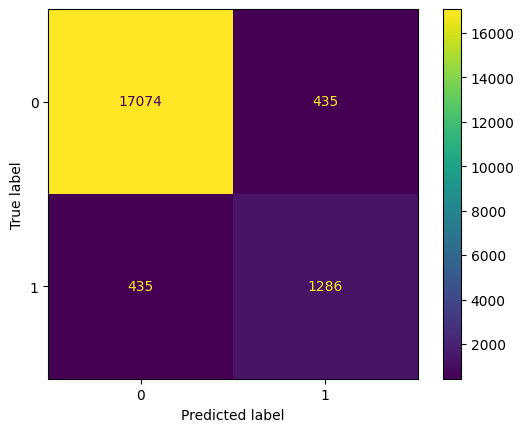

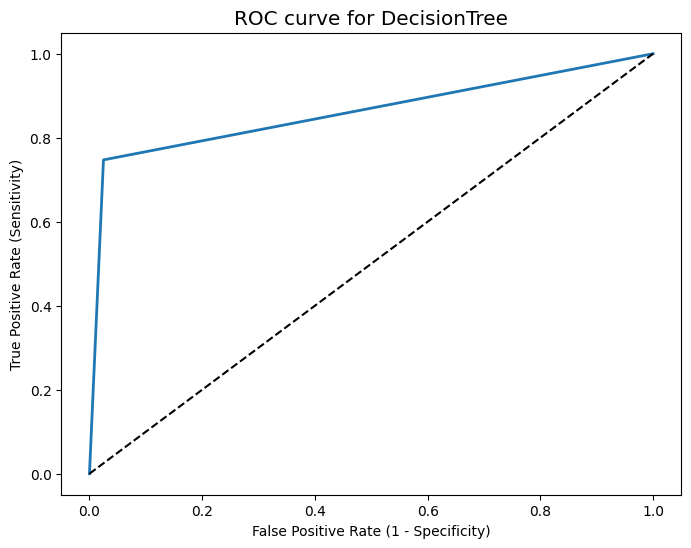


Evaluating KNeighbour....
Accuracy: 0.9081
Precision: 0.4910
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95     17509
           1       0.49      0.73      0.59      1721

    accuracy                           0.91     19230
   macro avg       0.73      0.83      0.77     19230
weighted avg       0.93      0.91      0.92     19230

**Confusion Matrix**


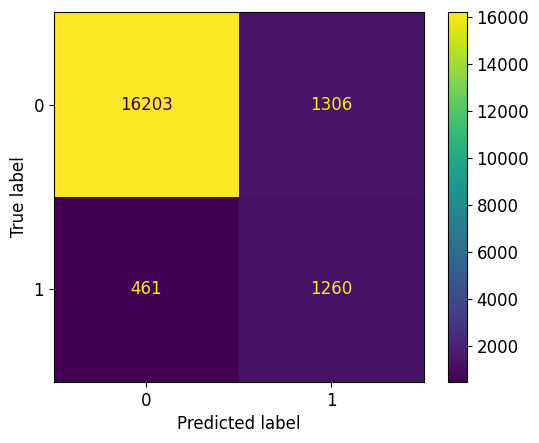

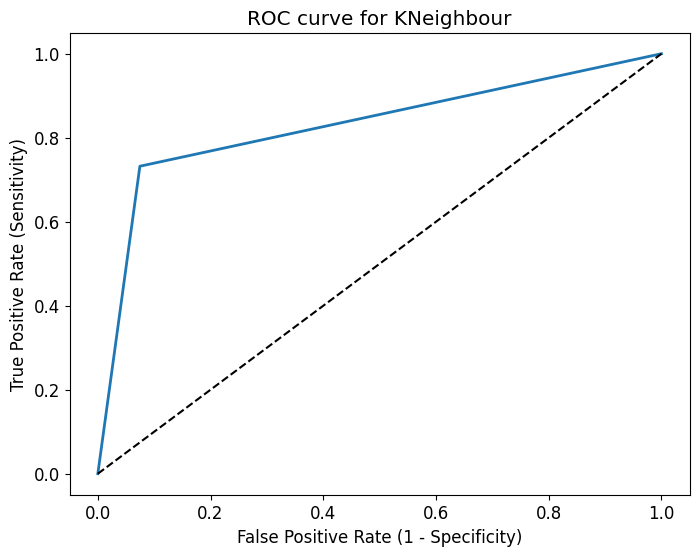


Evaluating Guass....
Accuracy: 0.8881
Precision: 0.4358
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.89      0.94     17509
           1       0.44      0.85      0.58      1721

    accuracy                           0.89     19230
   macro avg       0.71      0.87      0.76     19230
weighted avg       0.93      0.89      0.90     19230

**Confusion Matrix**


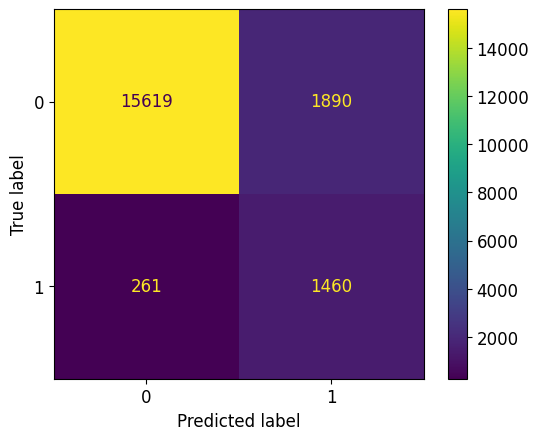

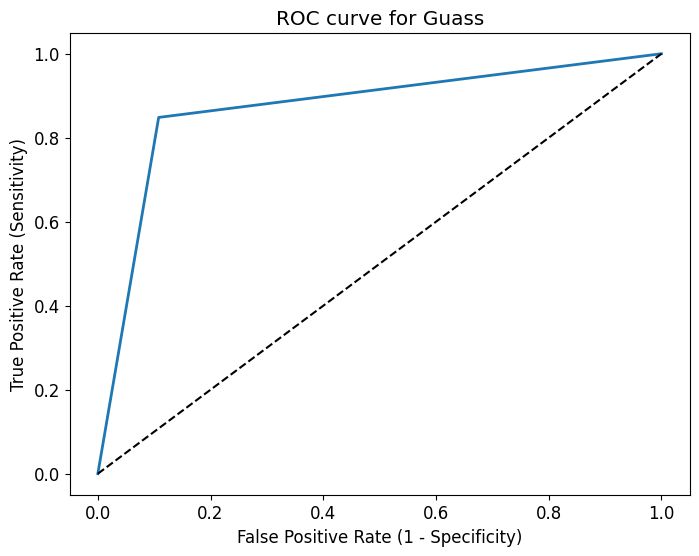


Evaluating Bern....
Accuracy: 0.6929
Precision: 0.1608
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.70      0.81     17509
           1       0.16      0.58      0.25      1721

    accuracy                           0.69     19230
   macro avg       0.55      0.64      0.53     19230
weighted avg       0.87      0.69      0.76     19230

**Confusion Matrix**


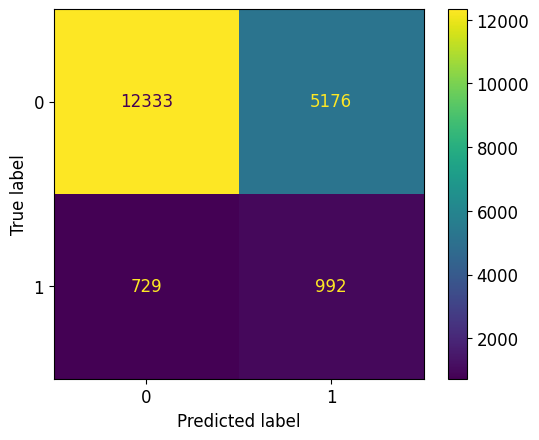

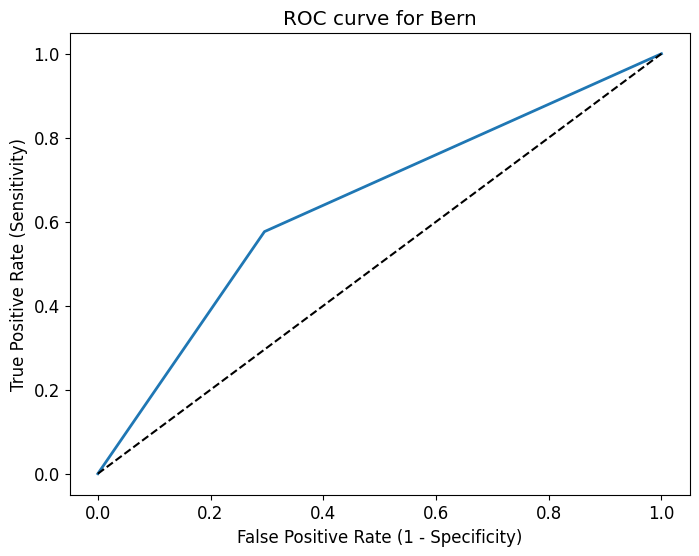

In [17]:
# Evaluate models
for model_name, model in best_models.items():
    print(f"\nEvaluating {model_name}....")
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_pred, y_test)
    prec = precision_score(y_pred, y_test)
    confusion_mat = confusion_matrix(y_pred, y_test)

    print(f"Accuracy: {accuracy_score(y_pred, y_test):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    conf = confusion_matrix(y_test, y_pred)
    print('**Confusion Matrix**')
    disp = ConfusionMatrixDisplay(conf, display_labels=map_class.keys())
    disp.plot()
    plt.show()
    
    # performance record
    performance_records.append({
        'Model' : model_name,
        'Accuracy' : acc,
        'Precision' : prec,
        'Confusion Matrix' : confusion_mat
    })
    
    # plot ROC
    n, p, _ = roc_curve(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(n, p, linewidth=2)
    plt.plot([0, 1], [0,1], 'k--')
    plt.rcParams['font.size'] = 12
    plt.title(f"ROC curve for {model_name}")
    plt.xlabel('False Positive Rate (1 - Specificity)')

    plt.ylabel('True Positive Rate (Sensitivity)')

    plt.show()

    print("="* 50)

    

In [18]:
# present the evaluation metrics in a dataframe

performance_df = pd.DataFrame(
   performance_records
   ).sort_values("Accuracy", ascending=False, ignore_index=True)

performance_df

,Model,Accuracy,Precision,Confusion Matrix
0,DecisionTree,0.954758,0.747240,"[[17074, 435], [435, 1286]]"
1,KNeighbour,0.908112,0.732132,"[[16203, 461], [1306, 1260]]"
2,Guass,0.888144,0.848344,"[[15619, 261], [1890, 1460]]"
3,Bern,0.692928,0.576409,"[[12333, 729], [5176, 992]]"


In [19]:
# save the best model

import pickle

file_name = "decisiontree.pkl"
pickle.dump(decisionTree, open(file_name, "wb"))